# Ceiba T/D Velocity Model Update Procedure

### Bash script listing:

```
AVG_VELOCITY="Cb_Ph3_TWT_Vavg_062013_32b.su"
Ceiba_WMP_FILE="ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat"

extract_delta_v < ${AVG_VELOCITY} pfile=${Ceiba_WMP_FILE} verbose=1 >\
ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis
awk '{if(NR>1){print $2, $3, $4, $10}}' ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis |\
sort -n | uniq > test.new1.dat

sum_data_t < test.new1.dat verbose=1 dt=1 | wc -l

# ************************************************ #

echo "Performing 4D Rbf Interpolation"
python test2.py test.new1.dat > bub

awk '{print $2, $3, $1, $4}' bub > bub1
echo "Appling the Delta-V corrections to background average velocities"
apply_delta_v.new < ${AVG_VELOCITY} pfile=bub1 nx=213 ny=445 nt=100 verbose=1 > test.su

# ************************************************ #

echo "Extracting the Residual Delta-V values from the corrected average velocity grid"
extract_delta_v < test.su pfile=${Ceiba_WMP_FILE} verbose=1 > output.deltav.lis
cat output.deltav.lis
echo
minmax output.deltav.lis
echo

sudepthconvert.v1 < ./SEGY_TWT/input1.trint.su vfile=test.su verbose=1 >\
output.su && segyhdrs < output.su && segywrite < output.su tape=test.depth.sgy endian=0
```

Set parameters for files containing Ceiba average velocities as a function of TWT (SU format) and ASCII listing of
well-marker picks (exported from interpretation application).  Setup bash environment variables and path to include programs and Seismic Unix.

In [15]:
%%%bash
source /u/10700029/.bashrc
cd /u/10700029/Ceiba.new
AVG_VELOCITY="Cb_Ph3_TWT_Vavg_062013_32b.su"
Ceiba_WMP_FILE="ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat"

Here is an example image of the TWT/Average-Velocity SU file - Inline 1540.

```
suwind < Cb_Ph3_TWT_Vavg_062013_32b.su key=gelev min=1540 max=1540 |\
suximage perc=100 cmap=hsv2 legend=1 title="Ceiba TWT/Vavg Inline 1540" label1="TWT (sec.)" label2="Xline values"\
units="m/sec" grid1=dot grid2=dot f2=2050 d2=1 &
```

Move the mouse inside the image window and type "q" to terminate the display.  Here is a screen-dump of the example image:

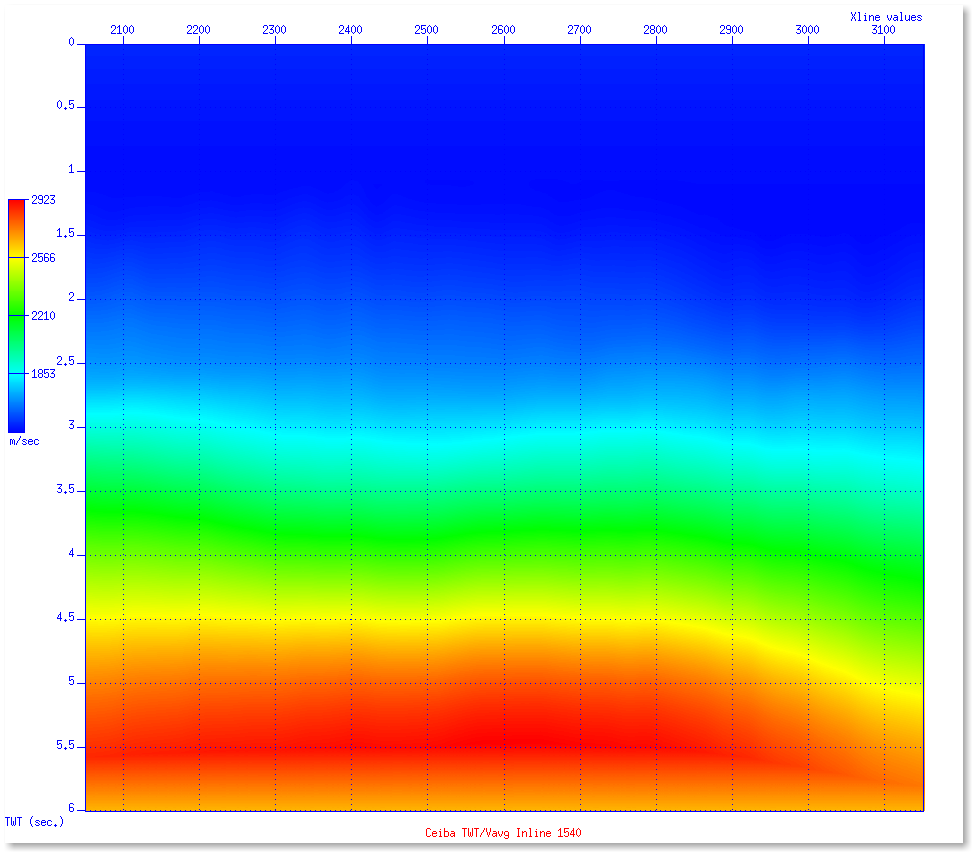

In [10]:
from IPython.display import Image
Image(filename='Ceiba_inline_1540_twt_vavg.png')

The contents and format of the ASCII well-marker picks file are listed below (first 20 and last 20 lines).  The columns are well name, x location, y location, two-way time in ms., and depth in meters (tvdss).

In [37]:
%%%bash
cat ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat | head -20
echo "..."
cat ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat | tail -20

C_01            520545.64    160669.56  3009.26  2889.09
C_01            520601.81    160671.51  2736.96  2386.06
C_01            520602.26    160671.69  2724.05  2364.66
C_01            520602.68    160671.93  2703.29  2336.92
C_01            520603.46    160672.26  2663.08  2278.28
C_01            520604.13    160672.23  2620.97  2231.31
C_01            520604.64    160672.05  2587.52  2191.10
C_01            520604.94    160671.86  2561.42  2160.09
C_01            520605.46    160671.54  2489.58  2078.41
C_02            519524.20    159750.76  2781.00  2406.36
C_02            519524.48    159749.76  2752.64  2371.31
C_02            519524.63    159748.63  2712.21  2322.94
C_02            519524.71    159748.06  2689.73  2296.05
C_02            519524.80    159747.62  2670.07  2272.53
C_02            519524.89    159747.00  2641.79  2238.70
C_02ST1         519526.55    159746.66  2641.83  2236.99
C_02ST1         519531.24    159745.58  2672.62  2272.51
C_02ST1         519535.61    15

Here is a listing of the "extract_delta_v" SU program, which is written in the C language:

In [8]:
cat extract_delta_v.c

#include <stdio.h>
#include "par.h"
#include "su.h"
#include "cwp.h"
#include "segy.h"

#define nint(x)  ((x) < 0 ? ceil ( (x) - 0.5 ) : floor ( (x) + 0.5 ))
#define min(a,b) ((a) <= (b) ? (a) : (b))
#define max(a,b) ((a) >= (b) ? (a) : (b))

char *sdoc[] = {NULL};
/* Joseph J. Oravetz - 2015 */

segy tr;

int main (int argc, char **argv) {

   char well[40], temp[256];
   int imin, ntr, ns, kount, index;
   float factor1, seismic_depth;
   float dt, scale_factor, seismic_vavg, delta_v, delta_z;
   float *x, *y, **data;
   double min_dist, dist, toler;
   double delrt, factor, x_loc, y_loc, twt, depth, average_velocity;
   FILE *fpp;
   cwp_String pfile;
   short verbose;
   register int i, j;

   initargs(argc, argv);

   if (!getparshort("verbose" , &verbose)) verbose = 0;
   if (!getparstring("pfile",&pfile)) pfile = "tops.lis";
   if (!getpardouble("toler",&toler)) toler = 12.50;
  
   fpp = efopen (pfile, "r");

   kount = 0;
   while (NULL != fgets ( temp, sizeof(temp), fpp )) {


Here is a listing of the Makefile to compile the programs:

In [7]:
cat Makefile

# Makefile for ...su/main

include $(CWPROOT)/src/Makefile.config

D = $L/libcwp.a $L/libpar.a $L/libsu.a $L/librecip.a
LFLAGS= -I/u/10700029/include -L$L -lsu -lpar -lcwp -lrecip -lm -L/u/10700029/lib64 -lgmt -lpsl -lnetcdf 

PROGS =			  \
	$B/joebob-vzerok  \
	$B/joebob-window-vzerok \
	$B/horizon-single-vzerok \
	$B/joebob-vzerok-triple \
	$B/joebob-vzerok-double \
	$B/horizon-joebob-vzerok-triple \
	$B/joebob-vzerok-poly-hybrid \
	$B/joebob-vzerok-vavg-vzero \
	$B/insert-campanian-surfaces \
	$B/joebob-vzerok-vavg \
	$B/inverse-horizon-vzerok \
	$B/suvzerok_with_water_seis_vavg_horizon \
	$B/supoly_with_water_seis_vavg_horizon \
	$B/sutest.vzerok.simulate \
	$B/sutest.vzerok.checkshots.simulate \
	$B/match.wmp.xy.to.deltav \
	$B/solveit \
	$B/extract_delta_v \
	$B/add_delta_v \
	$B/apply_delta_v \
	$B/apply_delta_v.new \
	$B/apply_deltav_v1 \
	$B/apply_deltav_revised \
	$B/apply_delta_v_check \
	$B/fix_xy_geometry_su_trace_headers \
	$B/intersect_checkshot_with_grid \
	$B/supoly \


Execute the command:

In [32]:
%%%bash
AVG_VELOCITY="Cb_Ph3_TWT_Vavg_062013_32b.su"
Ceiba_WMP_FILE="ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat"
extract_delta_v < ${AVG_VELOCITY} pfile=${Ceiba_WMP_FILE} verbose=1 > ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis 
awk '{if(NR>1){print $2, $3, $4, $10}}' ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis | sort -n | uniq > test.new1.dat


Number of traces = 992001, number of samples per trace = 3001
Time sample rate (milliseconds) = 2.000000
Coordinate scale factor = 1.000000
TOPS file name = ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat, number of input samples = 380
Minimum distance tolerance =    12.50 meters
Delrt = 0.000000, imin = 0

index = 569765, x_loc = 520545.640000, x_seismic = 520544.000000, y_loc = 160669.560000, y_seismic = 160673.000000, min_dist = 3.810932
sample = 1505
num =     0, Well = C_01       x_loc =  520545.64, y_loc =  160669.56, twt =  3009.26, depth =  2889.09
min_dist =     3.81, index = 569765, seismic velocity =  1852.94, well average velocity =  1920.13,         delta_z =   101.0983 meters, delta_v =    67.1915 meters per second
index = 574171, x_loc = 520601.810000, x_seismic = 520600.000000, y_loc = 160671.510000, y_seismic = 160674.000000, min_dist = 3.078344
sample = 1368
num =     1, Well = C_01       x_loc =  520601.81, y_loc =  160671.51, twt =  2736.96, depth =

Here is a listing of the file ***ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis*** (first and last 20 lines):

In [36]:
%%%bash
head -20 ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis
echo "..."
tail -20 ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED.deltav.lis

well x_loc y_loc twt well_depth seismic_depth seismic_vavg average_velocity delta_z delta_v
C_01              520545.64  160669.56  3009.26  2889.09  2787.99  1852.94  1920.13   101.098297    67.191536
C_01              520601.81  160671.51  2736.96  2386.06  2391.52  1747.57  1743.58    -5.458066    -3.988387
C_01              520602.26  160671.69  2724.05  2364.66  2374.98  1743.71  1736.14   -10.322178    -7.578456
C_01              520602.68  160671.93  2703.29  2336.92  2348.52  1737.52  1728.95   -11.595869    -8.579070
C_01              520603.46  160672.26  2663.08  2278.28  2298.15  1725.94  1711.01   -19.874784   -14.926067
C_01              520604.13  160672.23  2620.97  2231.31  2246.41  1714.18  1702.66   -15.095517   -11.518887
C_01              520604.64  160672.05  2587.52  2191.10  2207.37  1706.16  1693.59   -16.267675   -12.573898
C_01              520604.94  160671.86  2561.42  2160.09  2177.18  1699.98  1686.63   -17.091640   -13.345345
C_01              520605.46 

The ASCII output file, ***test.new1.dat***, is listed below (first 20 lines).

In [26]:
cat test.new1.dat | head -20

517516.81 162208.71 3262.81 -27.314121
517552.66 157275.91 2844.73 -27.333351
517580.11 157324.82 2816.60 -24.361296
517599.07 157357.38 2797.40 -21.800570
517609.16 157374.25 2787.44 -20.332153
517642.12 157430.38 2753.80 -16.531557
517676.73 162149.86 3156.30 -10.601546
517786.56 158549.48 2673.00 -15.474018
517788.42 158479.36 2710.37 -18.606308
517794.79 158447.35 2723.46 -19.454020
517806.09 162104.79 3074.14 -1.858818
517834.82 158315.38 2761.75 -19.451628
517910.51 162070.71 3016.52 -3.477117
517938.87 162062.06 2999.51 -3.447335
518028.81 162034.78 2948.17 -5.683984
518065.74 162023.79 2926.13 -6.823893
518179.20 161990.84 2856.31 -8.100307
518208.31 161346.78 2867.42 -6.731634
518223.12 161216.82 2820.59 -9.110809
518233.33 161077.31 2768.52 -10.069737


Compute the dimensions for the 4-D radial basis function interpolation script. Use dx = 25 and dy = 25 meters.

In [40]:
%%%bash
sum_data_t < test.new1.dat verbose=1 dt=1 | wc -l

386


Number of input elements =   381, xmin = 517516.81, xmax = 522828.79, ymin = 154902.60, ymax = 166010.29, tmin = 2458.32, tmax = 3262.81
dx = 25.00, dy = 25.00, dt = 1.00, nx =   213, ny =   445, nt =   805


For this particular example, the problem dimensions for the following script should be nx=213 and ny=445.  We will set nt=100 to cover the Campanian zone of interest.  Here is the simple python script:

In [7]:
cat test2.py

import sys
import numpy as np
from scipy.interpolate import Rbf

### Joe Oravetz - 2016 ###

def main():
    # Setup: Generate data...

    nx, ny, nt = 213, 445, 100

    filename = sys.argv[-1]
    my_data = np.genfromtxt ( filename, delimiter=' ',skip_header=0 )
    x = my_data[:,0]
    y = my_data[:,1]
    t = my_data[:,2]
    z = my_data[:,3]

    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    ti = np.linspace(t.min(), t.max(), nt)

    xi_orig = np.linspace(x.min(), x.max(), nx)
    yi_orig = np.linspace(y.min(), y.max(), ny)
    ti_orig = np.linspace(t.min(), t.max(), nt)

    xi, yi, ti = np.meshgrid(xi, yi, ti)
    xi, yi, ti = xi.flatten(), yi.flatten(), ti.flatten()

    # Calculate scipy's RBF
    grid2 = scipy_idw(x,y,t,z,xi,yi,ti)
    grid2 = grid2.reshape((ny, nx, nt))

    for i in range ( 0, nt ):
       for j in range ( 0, nx ):
          for k in range ( 0, ny ) :
             print ti_orig[i], xi_orig[j], yi_orig[k], grid2[k,j,

Execute the script - takes time and memory.  Please be patient, as the python script needs about 180 GB of memory to execute (for this example).  The total run-time should be approximately 8-10 minutes.

In [ ]:
python test2.py test.new1.dat > bub

The first and last 20 lines of the interpolated, delta-v output file (bub) are listed below.  The columns are TWT, X, Y, and Delta-Velocity.

In [2]:
%%%bash
head -20 bub
echo "..."
tail -20 bub

2458.32 517516.81 154902.6 -20.041327009
2458.32 517516.81 154927.61732 -20.0586546763
2458.32 517516.81 154952.63464 -20.0767093644
2458.32 517516.81 154977.651959 -20.0954883218
2458.32 517516.81 155002.669279 -20.1149888905
2458.32 517516.81 155027.686599 -20.1352085054
2458.32 517516.81 155052.703919 -20.1561446919
2458.32 517516.81 155077.721239 -20.1777950597
2458.32 517516.81 155102.738559 -20.2001572955
2458.32 517516.81 155127.755878 -20.2232291529
2458.32 517516.81 155152.773198 -20.2470084397
2458.32 517516.81 155177.790518 -20.2714930032
2458.32 517516.81 155202.807838 -20.296680713
2458.32 517516.81 155227.825158 -20.3225694414
2458.32 517516.81 155252.842477 -20.3491570419
2458.32 517516.81 155277.859797 -20.3764413248
2458.32 517516.81 155302.877117 -20.4044200311
2458.32 517516.81 155327.894437 -20.4330908047
2458.32 517516.81 155352.911757 -20.462451161
2458.32 517516.81 155377.929077 -20.4924984552
...
3262.81 522828.79 165534.960923 -2.39516406124
3262.81 522828.79 1

The next step is to apply the interpolated delta-v values to the original average-velocity model.  The parameter dimensions must be the same as in the python script above (NX, NY, and NT).

In [4]:
%%%bash
AVG_VELOCITY="Cb_Ph3_TWT_Vavg_062013_32b.su"
awk '{print $2, $3, $1, $4}' bub > bub1
echo "Appling the Delta-V corrections to background average velocities"
apply_delta_v.new < ${AVG_VELOCITY} pfile=bub1 nx=213 ny=445 nt=100 verbose=1 > test.su

Appling the Delta-V corrections to background average velocities



Delta-V file name = bub1, number of input samples = 9478500
Xmin = 517516.81, Xmax = 522828.79, Ymin = 154902.60, Ymax = 166010.29, Tmin = 2458.32, Tmax = 3262.81
Delta-X = 25.0565, Delta-Y = 25.0173, Delta-T = 8.1262
NX = 213, NY = 445, NT = 100

Number of traces = 992001, number of samples per trace = 3001
Time sample rate (milliseconds) = 2.000000
Coordinate scale factor = 1.000000



Here is a listing of the "***apply_delta_v.new.c***" program:

In [9]:
cat apply_delta_v.new.c

#include <stdio.h>
#include "par.h"
#include "su.h"
#include "cwp.h"
#include "segy.h"

#define min(a,b) ((a) <= (b) ? (a) : (b))
#define max(a,b) ((a) >= (b) ? (a) : (b))
#define abs(x)   ( (x) <  0  ? -(x) : (x) )
#define nint(x)  ((x) < 0 ? ceil ( (x) - 0.5 ) : floor ( (x) + 0.5 ))

char *sdoc[] = {NULL};
/* Joseph J. Oravetz - 2015 */

segy tr;

int main (int argc, char **argv) {

   char temp[256];
   FILE *fpp;
   cwp_String pfile;
   short verbose;
   register int i, j, k, l;

   int nxm1, nym1, ntm1;
   int ntr, ns, kount, iloc, jloc, nx, ny, nt;
   double xmin, xmax, ymin, ymax, tmin, tmax, delta_x, delta_y, delta_t;
   double xref, yref, tref, x_loc, y_loc, twt, delta_v;
   double *x_dv, *y_dv, ***dv;

   double x, y, time, dt, scale_factor;
   double *twt_array, *vavg_array, *twt_dv_array;

   initargs(argc, argv);

   if (!getparshort("verbose" , &verbose)) verbose = 0;
   if (!getparstring("pfile",&pfile)) pfile = "stuff.combined.dat";
   if (!getparint("nx",&nx)) nx = 901

Extracting the Residual Delta-V values from the corrected average velocity grid.

In [13]:
%%%bash
Ceiba_WMP_FILE="ALL_Ceiba_Campanian_WMPs_and_Checkshots_COMBINED_06-12-2016.dat"
echo "Extracting the Residual Delta-V values from the corrected average velocity grid"
extract_delta_v < test.su pfile=${Ceiba_WMP_FILE} verbose=0 > output.deltav.lis
cat output.deltav.lis
echo
minmax output.deltav.lis

Extracting the Residual Delta-V values from the corrected average velocity grid
well x_loc y_loc twt well_depth seismic_depth seismic_vavg average_velocity delta_z delta_v
C_01              520545.64  160669.56  3009.26  2889.09  2883.38  1916.34  1920.13     5.709385     3.794688
C_01              520601.81  160671.51  2736.96  2386.06  2385.62  1743.26  1743.58     0.438418     0.320451
C_01              520602.26  160671.69  2724.05  2364.66  2366.18  1737.25  1736.14    -1.521641    -1.117030
C_01              520602.68  160671.93  2703.29  2336.92  2336.54  1728.66  1728.95     0.382646     0.283235
C_01              520603.46  160672.26  2663.08  2278.28  2280.39  1712.60  1711.01    -2.109404    -1.584149
C_01              520604.13  160672.23  2620.97  2231.31  2230.49  1702.03  1702.66     0.821719     0.627110
C_01              520604.64  160672.05  2587.52  2191.10  2191.13  1693.61  1693.59    -0.025977    -0.020066
C_01              520604.94  160671.86  2561.42  2160.09  

Convert a trace-integrated, full-offset stack dataset from two-way time to depth using the new average velocity model.  The resulting SEG-Y depth file is "***test.depth.sgy***".

In [1]:
%%%bash
sudepthconvert.v1 < ./SEGY_TWT/input1.trint.su vfile=test.su verbose=1 > output.su 


Number of input traces = 1014021
Number of input samples per trace = 1801
Number of output samples per trace = 2000
Sample rate = 2.000000 ms.
Average velocity SU file name = test.su
Number of VAVG input traces = 992001
Number of VAVG input samples per trace = 3001
VAVG Sample rate = 2.000000 ms.
Delay = 0.000000 ms., First sample = 0

VELOCITY DATA - gelev_vmin = 1100, gelev_vmax = 2000, selev_vmin = 2050, selev_vmax = 3150
INPUT DATA -    gelev_min =  1080, gelev_max =  2000, selev_min =  2050, selev_max =  3150

gelev_globalmin = 1100, gelev_globalmax = 2000, selev_globalmin = 2050, selev_globalmax = 3150
gelev_num = 901, selev_num = 1101
ifirst = 0, dfirst = 0.000000, nz1 = 2000


Create an example output depth image of inline 1540.  Display the result.


```
suwind < output.su key=gelev min=1540 max=1540 tmax=3.45 | \
suximage perc=99 title="Ceiba Depth(m) Inline 1540" label1="Depth (m)" label2="Xline values"\
grid1=dot grid2=dot f2=2050 d2=1 &
```

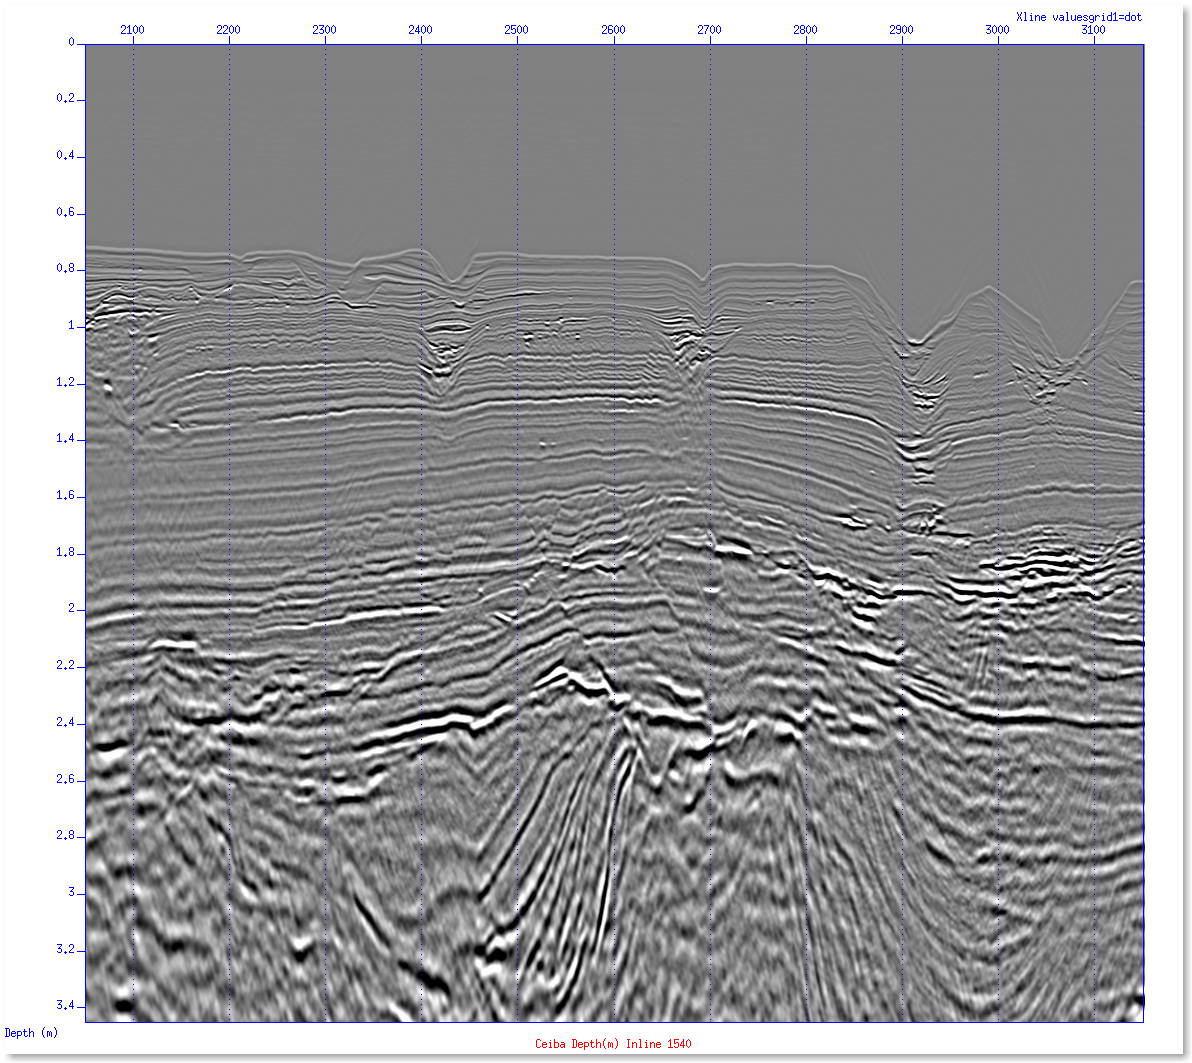

In [1]:
from IPython.display import Image
Image(filename='Ceiba_inline_1540_depth.png')

Here is a listing of the depth-conversion program "***sudepthconvert.v1***":

In [ ]:
cat sudepthconvert.v1.c

#include <stdio.h>
#include <stddef.h>
#include "par.h"
#include "su.h"
#include "cwp.h"
#include "segy.h"

#define abs(x)   ( (x) <  0  ? -(x) : (x) )
#define min(a,b) ((a) <= (b) ? (a) : (b))
#define max(a,b) ((a) >= (b) ? (a) : (b))
#define nint(x)  ((x) < 0 ? ceil ( (x) - 0.5 ) : floor ( (x) + 0.5 ))

char *sdoc[] = {NULL};
/* Joseph J. Oravetz - 2015 */

segy tr, vtr;

int main(int argc, char **argv) {

int  gelev_vmin, gelev_vmax, selev_vmin, selev_vmax;
int  gelev_min, gelev_max, selev_min, selev_max;
int  gelev_globalmin, gelev_globalmax, selev_globalmin, selev_globalmax;
int  gelev_num, selev_num;
int  kk, imin, ifirst, nz1, nz, ns, ntr, ntrv, nsv;
double dfirst, delrt, twt, dt, dtv, factor, z, amp_out;
double *depth, *tr_amp;
float ***velocity;
short verbose;
register int i, j, k, l;
cwp_String vfile;
FILE *fv;

initargs(argc, argv);
requestdoc (0);

if (!getparshort("verbose", &verbose)) verbose = 1;
if (!getparstring("vfile",&vfile)) vfile = "output.su";

ntr = gettra (&tr,

Convert the SU file to SEG-Y.  First create binary and EBCDIC headers from ***segyhdrs*** program.
```
suwind < output.su key=trid min=1 max=1 count=1 > foo
segyhdrs < foo
```

Finally, write the output SEG-Y depth volume (little endian).

In [2]:
%%%bash
segywrite < output.su tape=test.depth.sgy endian=0

6+1 records in
1+0 records out
3200 bytes (3.2 kB) copied, 9.218e-05 s, 34.7 MB/s
